# Entrenamiento de RNNs en una Serie de Tiempo

En esta sección emplearemos redes neuronales recurrentes para modelar series de tiempo, es decir una serie
de registros (tı́picamente valores reales) regularmente indexados en el tiempo. Para ello utilizaremos un dataset
denominado "*Minimum Daily Temperatures*", el cual describe la temperatura mínima diaria en un período de 10 años (1981 a 1990) en la ciudad de Melbourne, Australia. Las unidades de las 3670 observaciones fueron medidas en grados celsius. A continuación se muestra la secuencia de tiempo:
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/11/Minimum-Daily-Temperatures.png" width="60%" />



La tarea predictiva consiste en estimar la temperatura mínima diaria de algún día basado en la información de días anteriores.  
*La fuente es acreditada a Australian Bureau of Meteorology.*

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time

from tabulate import tabulate

import matplotlib.pyplot as plt 
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

> a) Escriba una función que cargue los datos, los divida en 1500 de entrenamiento y el resto (500) de pruebas. Además de esto escálelos apropiadamente para trabajar con redes recurrentes.

A continuación se cargan los datos desde el archivo "time_series_data.csv", que contiene 3.650 datos. Según lo indicado, se utilizan 1.500 datos para el conjunto de entrenamiento y 500 datos para el conjunto de prueba. Y, adicionalmente se crea un conjunto de validación con el resto de los datos.

Cada conjunto de datos es escalado mediante el Método *MinMaxScaler*, el cual transforma las carácteristicas, escanlando cada una de ellas a un rango determinado. En este caso en un rango [0,1], que está ajustado al conjunto de entrenamiento. Y luego, cada uno de los conjuntos de datos es escalado. Este procedimiento de normalización es importante, ya que nos permitirá trabajar adecuadamente con las redes recurrentes, y evitamos posible problemas númericos.

In [3]:
#cargar los datos y dividir
name_f = "time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test, df_val = dataframe[:1500].values, dataframe[1500:2000].values, dataframe[2000:].values

#escalar datos
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)
stream_val_scaled = scaler.transform(df_val)

Se ve que era necesario realizar la normalización de los datos, pues iban en un amplio rango (entre 0 y 26) con promerio en 11 y desviación estándar de 4. Así, se ve como esta acción nos permite evitar que los valores más altos tengan mayor peso.

In [4]:
print(dataframe.shape)
dataframe.describe()

(3650, 1)


,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.299999


In [5]:
dataframe.head()

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,20.700001
1,17.900000
2,18.799999
3,14.600000
4,15.800000


Se presenta el porcentaje de los datos totales que tiene cada conjunto

In [6]:
n_train = df_train.shape[0]
n_test = df_test.shape[0]
n_val = df_val.shape[0]
print("Datos de entrenamiento: ", n_train, ", correspondiente al ", n_train/dataframe.shape[0], "% de los datos")
print("Datos de prueba: ", n_test, ", correspondiente al ", n_test/dataframe.shape[0], "% de los datos")
print("Datos de validación: ", n_val, ", correspondiente al ", n_val/dataframe.shape[0], "% de los datos")

Datos de entrenamiento:  1500 , correspondiente al  0.410958904109589 % de los datos
Datos de prueba:  500 , correspondiente al  0.136986301369863 % de los datos
Datos de validación:  1650 , correspondiente al  0.4520547945205479 % de los datos


###### Análisis de los datos
A continuación se realiza un pequeño análisis de los conjuntos de datos.

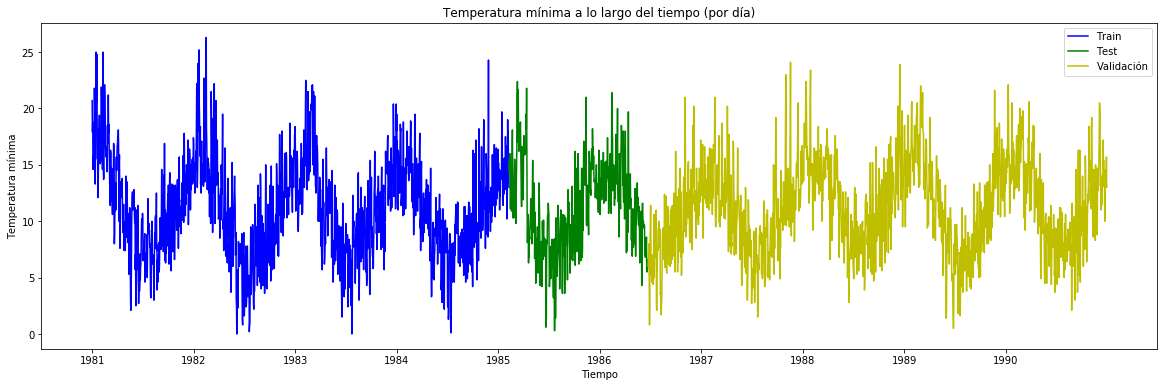

In [7]:
plt.figure(figsize=(20,6))
plt.plot(range(n_train),df_train, 'b', label="Train")
plt.plot(range(n_train-1,n_train+n_test-1),df_test, 'g', label= "Test")
plt.plot(range(n_train+n_test-1, n_train+n_test+n_val-1),df_val, 'y', label= "Validación")
plt.title("Temperatura mínima a lo largo del tiempo (por día)")
plt.ylabel("Temperatura mínima")
plt.xlabel("Tiempo")
plt.xticks(range(0, n_train+n_test+n_val, 365), list(range(1981, 1992)))
plt.legend(loc='upper right')
plt.show()

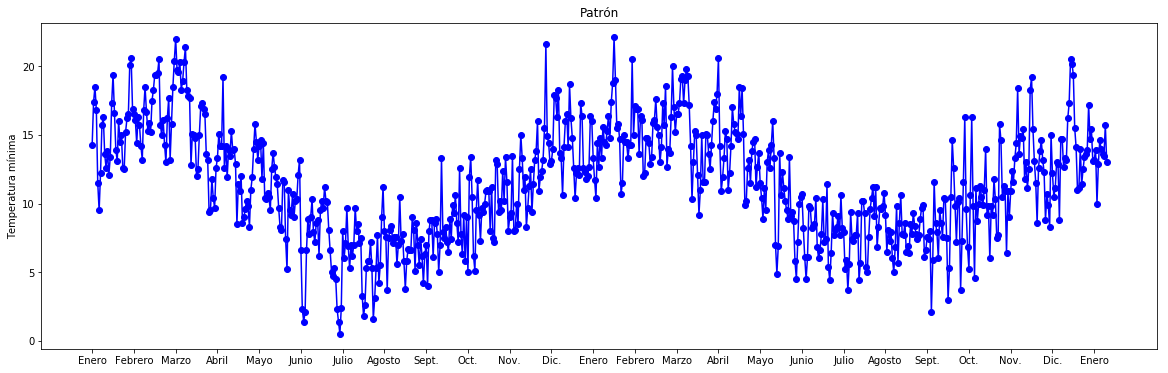

In [8]:
meses = ["Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Sept.","Oct.","Nov.","Dic."]
plt.figure(figsize=(20,6))
n = 730 #periodo
plt.plot(range(n),dataframe.values[-n:], 'bo-')
plt.title("Patrón")
plt.ylabel("Temperatura mínima")
plt.xticks( range(0,n,30), meses+meses+meses)
plt.show()

Se puede ver que la serie de tiempo tiene un ciclo por año, y que se ha mantenido en el tiempo por estos 10 años.

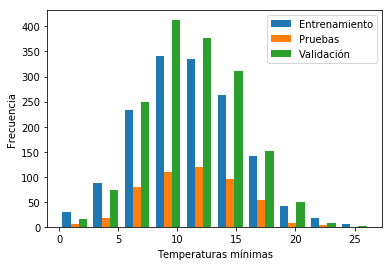

In [9]:
plt.hist([df_train, df_test, df_val], label=["Entrenamiento","Pruebas", "Validación"])
plt.xlabel("Temperaturas mínimas")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

Se ve como el porcentaje de datos que tiene cada conjunto influye en la frecuencia de las temperaturas. Sin embargo, se ve como entre entrenamiento y validación tienen frecuencias similares, considerando que tinen un porcentaje de los datos cercano. Mientras que los datos de prueba al tener menos proporción de los datos encuentra una menor frecuencia de los datos, sin embargo, estos tienen el mismo comportamiento de los conjuntos de prueba y validación por lo que se podría confiar en este conjunto.

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


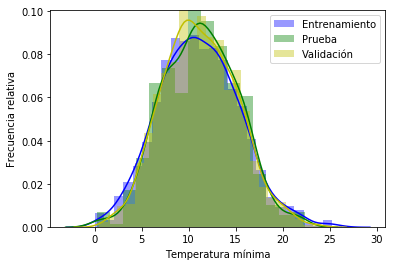

In [10]:
sns.distplot(df_train,color='b', label = "Entrenamiento")
sns.distplot(df_test, color='g', label = "Prueba")
sns.distplot(df_val, color='y', label = "Validación")
plt.ylabel("Frecuencia relativa")
plt.xlabel("Temperatura mínima")
plt.legend()
plt.show()

El gráfico anterior presenta el histograma de probabilidades, mostrando la distribución de probabilidades de los datos. Analizandolass, se puede ver como se superponen entre ellas, lo que quiere decir que los 3 conjuntos de datos tienen el mismo comportamientos, provienen de muestras de la misma población, por lo que se esperaría un buen entrenamiento de los datos, siempre y cuando los datos que vengan en un futuro sigan con esta tendencia, que si provienen de Melbourne se esperaría que se mantengan así.

Además a consecuencia de esto,se esperaría que las diferencias entre error de entrenamiento y prueba sean pequeños si la red aprende bien.

> b) Ahora nos gustarı́a manipular los datos, para que hagamos la predicción de la temperatura mínima para el tiempo siguiente usando la temperatura mínima de los últimos perı́odos de tiempo. El número de perı́odos de tiempos que usaremos se denomina lag. Por ejemplo, tendremos un lag igual a 3, si para predecir el valor $x_{t+1}$ en el tiempo siguiente usamos la información del tiempo actual $x_t$ y la de los dos perı́odos anteriores $x_{t-1}$ y $x_{t-2}$ como variables de entrada. Realice una función que reciba una secuencia de valores y la transforme en dos arreglos dataX (inputs) y dataY (targets) donde el número de caracterı́sticas de la la matriz de entrada (columnas) sea el número de tiempos que se considerarán como información (lag).

La siguiente función *create_dataset* genera las secuencias de los últimos períodos de tiempo necesarios para poder predecir la temperatura mínima del siguiente período de tiempo.

In [11]:
def create_dataset(dataset,lag = 1):
    dataX = []
    dataY =[]
    init = 0
    for i in range(lag,len(dataset)):        
        columnas_x = []
        for j in np.arange(init, init+lag):
            columnas_x += list(dataset[j])
        init +=1
        dataX.append(columnas_x)
        
        dataY += list(dataset[i]) 
    return np.array(dataX),np.array(dataY)

lag=3
data_x, data_y = create_dataset(stream_train_scaled, lag)

Un ejemplo de las secuencias generadas se ve a contuación.

In [12]:
largo = 12
sec_or = df_train[:largo]
print("Secuencia original de los primeros ",largo, " datos del set de entrenamiento:\n", sec_or.T[0])

print("\nSecuencia generada")
sec = []
for i in range(largo-lag):
    x= data_x[i]
    y= data_y[i]    
    sec += [ ["Dato " + str(i)]+ list(x) + [y] ] 
    
header_ex = ["-"] + ["X"+str(i) for i in range(lag)] + ["Y"]
print(tabulate(sec, headers = header_ex, tablefmt = "fancy_grid"))

Secuencia original de los primeros  12  datos del set de entrenamiento:
 [20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3]

Secuencia generada
╒════════╤══════════╤══════════╤══════════╤══════════╕
│ -      │       X0 │       X1 │       X2 │        Y │
╞════════╪══════════╪══════════╪══════════╪══════════╡
│ Dato 0 │ 0.787072 │ 0.680608 │ 0.714829 │ 0.555133 │
├────────┼──────────┼──────────┼──────────┼──────────┤
│ Dato 1 │ 0.680608 │ 0.714829 │ 0.555133 │ 0.600761 │
├────────┼──────────┼──────────┼──────────┼──────────┤
│ Dato 2 │ 0.714829 │ 0.555133 │ 0.600761 │ 0.600761 │
├────────┼──────────┼──────────┼──────────┼──────────┤
│ Dato 3 │ 0.555133 │ 0.600761 │ 0.600761 │ 0.600761 │
├────────┼──────────┼──────────┼──────────┼──────────┤
│ Dato 4 │ 0.600761 │ 0.600761 │ 0.600761 │ 0.661597 │
├────────┼──────────┼──────────┼──────────┼──────────┤
│ Dato 5 │ 0.600761 │ 0.600761 │ 0.661597 │ 0.828897 │
├────────┼──────────┼──────────┼──────────┼──────────┤
│ Dato 6 │ 0.600761 

Así será el formato de los datos que recibirá la red recurrente, en donde el input (características) son las presentadas en las columnas *X*, que en este caso son tres debido al *lag* definido, y el output (predicción) se presenta en la columna *Y*.

> c) Usando la función anterior genere los conjuntos de entrenamiento y test para el problema.
```python
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
```


A continuación se generan los 3 conjuntos de datos (entrenamiento, prueba, validación) con la estructura necesaria para ser utilizados por la red recurrente, mediante la función *create_dataset* con un *lag* igual a 3.

In [13]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
valX, valY = create_dataset(stream_val_scaled, lag)

> d) En estos momentos tenemos nuestros datos en la forma [ejemplos, atributos]. Sin embargo, la red LSTM necesita que los datos se encuentren en un arreglo de tres dimensiones [samples, time steps, features]. Transforme el train y test sets a la estructura deseada.
```python
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
```

La librería de *Keras* requiere que los conjuntos de datos con que trabajan las redes recurrentes sean con un arreglo de 3 dimenciones: [ejemplos, time steps, características], donde el time steps indica los datos utilizados para hacer una predicción.

In [14]:
(trainX.shape[0], 1, trainX.shape[1])

(1497, 1, 3)

Así, en este caso se toma un solo dato que tiene 3 característica representados en la secuencia.

In [15]:
train_x_1 = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
test_x_1 = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
val_x_1 = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

> e) Entrene una LSTM usando un lag de 3
```python
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
```

A continuación se entrena un red recurrente Long Short-Term Memory (LSTM) con los datos de entrenamientos y validación generados anteriormente con *lag* 3. La arquitectura de la red cuenta con una capa oculta LSTM con función de activación tangente hiperbólica y función de activación para la conexión recurrente de sigmoidal, y luego, con una capa de salida lineal para predecir el valor de la temperatura.

In [16]:
model1 = Sequential()
model1.add(LSTM(4, input_shape=(1,lag), activation='tanh', recurrent_activation='sigmoid'))
model1.add(Dense(1,activation='linear'))
epochs = 25
batch_size=1
model1.compile(loss='mean_squared_error', optimizer='adam')

start_time = time.time()
hist_m1 = model1.fit(train_x_1, trainY, epochs=epochs, batch_size=batch_size, validation_data=(val_x_1, valY), 
                     verbose=1)
time_model1 = time.time() - start_time
print('Tiempo de entrenamiento: ',time_model1, '[s]')

Train on 1497 samples, validate on 1647 samples
Epoch 1/25
1497/1497 [==============================] - 5s 3ms/step - loss: 0.0266 - val_loss: 0.0104
Epoch 2/25
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0114 - val_loss: 0.0096
Epoch 3/25
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0109 - val_loss: 0.0092
Epoch 4/25
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0106 - val_loss: 0.0090
Epoch 5/25
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0105 - val_loss: 0.0090
Epoch 6/25
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0104 - val_loss: 0.0088
Epoch 7/25
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 8/25
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 9/25
1497/1497 [==============================] - 4s 3ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 10/25
1497/1497 [===========

In [17]:
def plot_error(hist, epochs):
    plt.figure(1, figsize=(15,6))

    plt.subplot(121)
    plt.plot(range(epochs), hist.history['loss'])
    plt.title("Error durante el entrenamiento")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    
    plt.subplot(122)
    plt.plot(range(epochs), hist.history['val_loss'])
    plt.title("Error de validación durante el entrenamiento")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    
    plt.show()

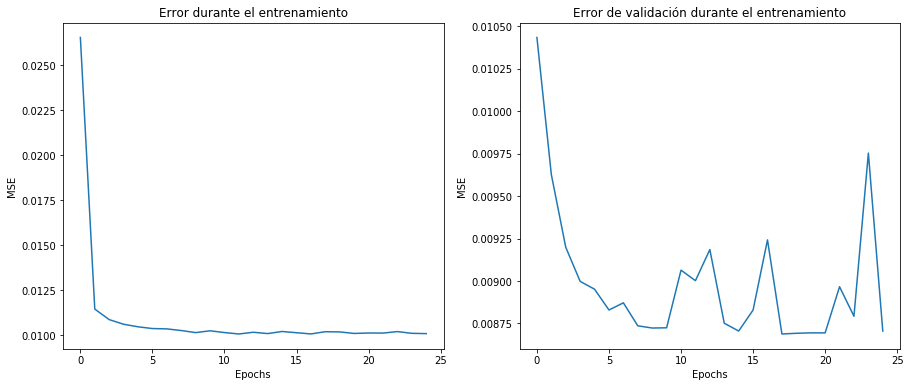

In [18]:
plot_error(hist_m1, epochs)

Mediante los gráficos anteriores se puede ver la evolución del comportamiento de la función de pérdida Mean Square Error (MSE), a través de los 25 epochs sobre el conjunto de entrenamiento y validación. Se puede ver que el MSE tiene un decaimiento suave durante el entrenamiento, llegando a $0.0100$ tempranamente, antes de los 5 epochs. No así el MSE en el conjunto de validación, en donde se ve un decaimiento bastante inestable, pero es mucho menor que el anterior, inclusive partiendo desde $0.0105$, muy cercano al nivel más bajo del error en el conjunto de entrenamiento.

> f) Realice las predicciones del modelo para los conjuntos de entrenamiento y prueba. Denormalice los datos para que el error pueda ser computado en la escala original.
```python
trainPredict = model.predict(trainX,batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainP)
trainY = scaler.inverse_transform([trainY])
```


A continuación se realizan las predicciones tanto para el conjunto de prueba como para el de validación. Dichas predicciones estarán en el rango [0,1], por lo que se debe invertir el escalamiento realizado originalmente para obtener la predicción real de la temperatura.

In [19]:
#entrenamiento
train_predict = model1.predict(train_x_1, batch_size=batch_size)
trainPredict = scaler.inverse_transform(train_predict)
train_y_original = scaler.inverse_transform([trainY])

In [20]:
#prueba
test_predict = model1.predict(test_x_1, batch_size=batch_size)
testPredict = scaler.inverse_transform(test_predict)
test_y_original = scaler.inverse_transform([testY])

g) Compute el root mean square error (RMSE) sobre los conjuntos de entrenamiento y test, comente.
```python
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
```

A continuación se calcula el Root Mean Square Error (RMSE), que cuantifica la diferencia entre el valor predecido por la red y el valor real, es decir, el error real. Esta diferencia es calculada en base a los valores reales (temperaturas mínimas medidas en grados celcius).

In [21]:
trainScore = np.sqrt(mean_squared_error(train_y_original[0], trainPredict[:,0]))
print('RMSE de entrenamiento: ', trainScore)
testScore = np.sqrt(mean_squared_error(test_y_original[0], testPredict[:,0]))
print('RMSE de prueba: ', testScore)

RMSE de entrenamiento:  2.618587007691994
RMSE de prueba:  2.4111206681233726


Lo primero que se puede notar es que los valores obtenidos son muy parecidos, y que puede ser explicado por la similitud de distribuciones de probabilidad entre los conjuntos de entrenamiento y prueba.

Se puede ver que el error obtenido no es tan alto, teniendo en consideración que los valores reales tienen una deviación estándar de 4°. Además, el RMSE de prueba es menor que el de entrenamiento, situación poco común. Así, se puede podría pensar que la red está entrenando bien.

A continuación se generan dos funciones que realizan lo hecho en las letras *f* y *g* respectivamente.

In [16]:
def predict(model, x, batch_size):
    predict = model.predict(x, batch_size=batch_size)
    predict = scaler.inverse_transform(predict)
    return predict

def compute_rmse(model, x, y, batch_size):
    predict_y = predict(model, x, batch_size)
    original = scaler.inverse_transform([y])    
    score = np.sqrt(mean_squared_error(original[0], predict_y[:,0]))
    return score

> h) Grafique las predicciones del train y test set, y contrástelas con la serie de tiempo original. Muestre un extracto de la predicción para ver en mas detalle cómo es la predicción, comente.
```python
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredic
```

A continuación se crean dos funciones que permiten gráficar las predicciones reales hechas por la red, y son comparadas con los datos reales.

In [17]:
def shift_predict(dataframe, trainPredict, testPredict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataframe.values[:2000])
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataframe.values[:2000])
    testPredictPlot[:, :] = np.nan
    testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
    
    return trainPredictPlot, testPredictPlot

In [18]:
def plot_predict(dataframe, train, test):
    plt.figure(figsize=(15,7))
    plt.plot(dataframe.values[:2000],'r', label = "Datos reales")
    plt.plot(train,'m', label= "Predicción de entrenamiento")
    plt.plot(test,'b', label= "Predicción de pruebas")
    plt.ylim(0)
    plt.ylabel("Temperatura mínima")
    plt.xlabel("Tiempo")
    plt.title("Temperatura mínima a lo largo del tiempo")
    plt.legend(loc="upper right")
    plt.show()

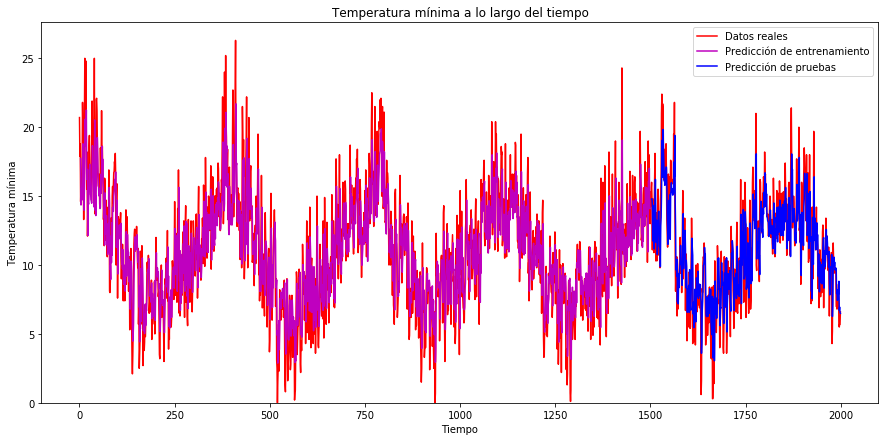

In [25]:
trainPredictPlot, testPredictPlot = shift_predict(dataframe, trainPredict, testPredict)
plot_predict(dataframe, trainPredictPlot, testPredictPlot)

La gráfica presenta la serie de tiempo original en color rojo, y superpuesta a ésta, se pueden ver las predicciones realizadas por la red entrenada sobre los datos de entrenamiento en morado y datos se prueba en azul

Se pueden ver que las predicciones realizadas por la red tienen un comportamiento bastante parecido al original. La excepción se produce en los valores extremos, donde los valores de 0° o 25°, por ejemplo, no son alcanzados por las predicciones.


> i) En lugar de aumentar el número de dimensiones como el el paso e), entrene la red con un timestep de 3 (con dimensión de entrada 1). ¿Se produce una mejora del error de entrenamiento y pruebas? ¿Los tiempos de computación son comparables? Comente brevemente sobre cual es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e).
```python
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
model = Sequential()
model.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
```

Se crea una nueva arquitectura de red, que básicamente corresponde a la misma que en la letra e), pero con un cambio en la forma del input que tendrá la misma. Cada input tendrá 3 timestep de 1 una característica, que corresponde al valor en un tiempo *t* de la secuencia). A pesar de este cambio de arquitectura, en el fondo la red seguirá prediciendo lo mismo, la siguiente temperatura mínima, mediante los 3 tiempos anteriores. Solo que ahora toma los datos de una forma diferente, tal que cada valor en el tiempo *t* se tratará como un elemento de la secuencia en vez de un conjunto de 3 características como en la versión anterior. Así, para este entrenamiento sería [ejemplos, time steps, características]: [1497, 3, 1]

In [26]:
train_x_2 = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
test_x_2 = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
val_x_2 = np.reshape(valX, (valX.shape[0], valX.shape[1], 1))

model2 = Sequential()
model2.add(LSTM(4, input_shape=(lag,1), activation='tanh', recurrent_activation='sigmoid'))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
hist_m2 = model2.fit(train_x_2, trainY, epochs=25, batch_size=1, validation_data=(val_x_2, valY), verbose=1)
time_m2 = time.time() - start_time
print('Tiempo de entrenamiento: ',time_m2, '[s]')

Train on 1497 samples, validate on 1647 samples
Epoch 1/25
1497/1497 [==============================] - 6s 4ms/step - loss: 0.0158 - val_loss: 0.0105
Epoch 2/25
1497/1497 [==============================] - 5s 3ms/step - loss: 0.0114 - val_loss: 0.0097
Epoch 3/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 4/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0110 - val_loss: 0.0095
Epoch 5/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 6/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0107 - val_loss: 0.0094
Epoch 7/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0105 - val_loss: 0.0090
Epoch 8/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0105 - val_loss: 0.0095
Epoch 9/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0104 - val_loss: 0.0091
Epoch 10/25
1497/1497 [===========

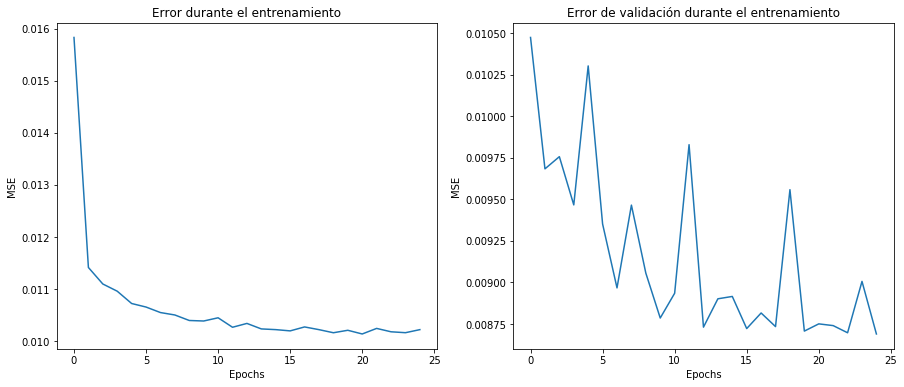

In [27]:
plot_error(hist_m2, epochs)

In [28]:
e_train_m2 = compute_rmse(model2, train_x_2, trainY, batch_size)
e_test_m2 = compute_rmse(model2, test_x_2, testY, batch_size)
print('RMSE de entrenamiento: ', e_train_m2)
print('RMSE de prueba: ', e_test_m2)

RMSE de entrenamiento:  2.6202909808874506
RMSE de prueba:  2.416358086233985


Se puede ver como esta arquitectura sigue funcionando bastante bien, en cuanto a la función de pérdida MSE y el error RMSE, obteniendo valores muy similares al modelo anterior definido en e).

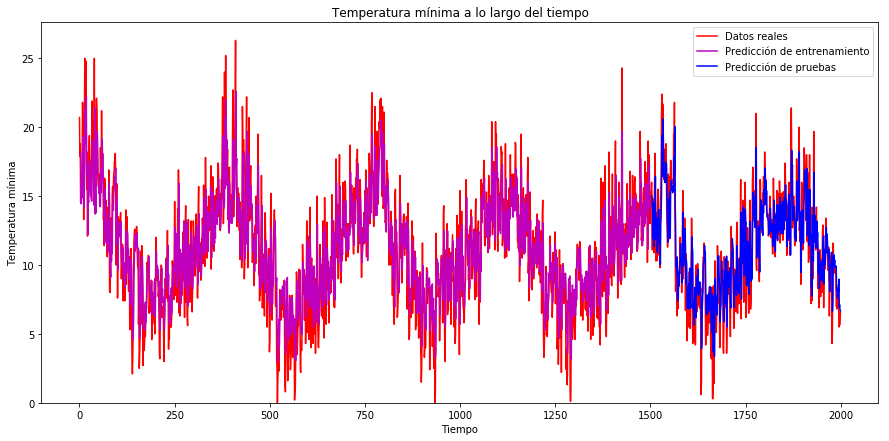

In [29]:
trainPredict_2 = predict(model2, train_x_2, batch_size)
testPredict_2  = predict(model2, test_x_2,  batch_size) 
trainPredictPlot_2, testPredictPlot_2 = shift_predict(dataframe, trainPredict_2, testPredict_2)
plot_predict(dataframe, trainPredictPlot_2, testPredictPlot_2)

Mediante la gráfica anterior, también se puede verificar como las predicciones realizadas por esta red son bastante similares a los de la red anterior, ya que siguen el mismo patrón de la red original, sin embargo no logran alcanzar los valores extremos.

Dado que la diferencia entre el modelo actual y el anterior (letra e) no son considerables, por lo uqe no es fácil identificar cual es mejor o peor, se procede a realizar una comparación más al detalle de estos dos modelos en cuestión.

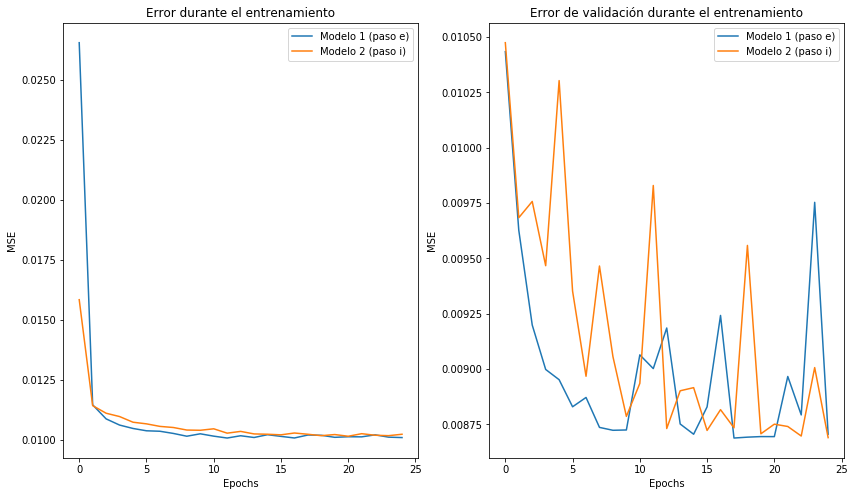

In [30]:
def plot_compare_2(hist_m1, hist_m2, label1, label2, epochs):
    plt.figure(1, figsize=(14,8))

    plt.subplot(121)
    plt.plot(range(epochs), hist_m1.history['loss'], label=label1)
    plt.plot(range(epochs), hist_m2.history['loss'], label=label2)
    plt.title("Error durante el entrenamiento")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(122)
    plt.plot(range(epochs), hist_m1.history['val_loss'], label=label1)
    plt.plot(range(epochs), hist_m2.history['val_loss'], label=label2)
    plt.title("Error de validación durante el entrenamiento")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()
    
plot_compare_2(hist_m1, hist_m2, "Modelo 1 (paso e)", "Modelo 2 (paso i)", epochs)

In [50]:
print(tabulate([['Modelo 1 (paso e)', trainScore, testScore, time_model1],['Modelo 2 (paso i)', e_train_m2, e_test_m2, time_m2]], 
            ['Modelo', 'Error entrenamiento', 'Error prueba', 'Tiempo'], tablefmt = "fancy_grid"))

╒═══════════════════╤═══════════════════════╤════════════════╤══════════╕
│ Modelo            │   Error entrenamiento │   Error prueba │   Tiempo │
╞═══════════════════╪═══════════════════════╪════════════════╪══════════╡
│ Modelo 1 (paso e) │               2.61859 │        2.41112 │  100.907 │
├───────────────────┼───────────────────────┼────────────────┼──────────┤
│ Modelo 2 (paso i) │               2.62029 │        2.41636 │  136.304 │
╘═══════════════════╧═══════════════════════╧════════════════╧══════════╛


Gracias a la gráfica y tabla anterior, es más fácil realizar una comparación del rendimiento de ambas redes recurrentes. Mediante los gráficos de MSE se puede ver que el error en el conjunto de entrenamiento tiene una pequeña diferencia entre ambos modelos. Por un lado el Modelo 2 comienza con un menor error que el Modelo 1, pero luego del paso de los epochs, el Modelo 1 logra obtener una pequeña mejora, manteniendo esta situación hasta el final de los epochs. En el conjunto de validación, se ve que en general el Modelo 1 se comporta mejor, excepto en el penúltimo epoch.

Analizando el error RMSE presentado en la tabla, tanto en el conjunto de entrenamiento como en el de prueba el Modelo 1 tiene un mejor rendimiento, aunque este es muy pequeño. Además, el tiempo de ejecución es menor en el Modelo 1.

Por lo tanto, respondiendo a las preguntas, con este modelo no se produce una mejor en el error de entrenamiento y pruebas. Los tiempos de computación de entrenamiento, a pesar de tener diferentes representación, con diferente dimensionalidad, consideramos que si son comparables, dado que el resto de la arquitectura se deja igual, y se monitores sólo este cambio.

Además, es posible desprender que al usar una representación de los datos con 1 timestep y 3 características es mejor, dado que se está trabajando con una secuencia. Lo que se puede pensar que también podría ser ejecutado por una Feed Forward.

> j) Determine el parámetro del número de bloques para la LSTM de la pregunta e) o i), lo que le parezca mas sensato en base a lo analizado en la pregunta anterior. Utilice 5-fold cross validation, o bien, en su defecto, los datos restante no utilizados ni como entrenamiento ni como pruebas (los de índice 2000 hacia adelante) como conjunto fijo de validación. Comente.
```python
nb = range(4,13,2)
model = Sequential()
model.add(LSTM(nb=range(4,13,2),input_dim=choose,activation='tanh',inner_activation='sigmoid'))
model.add(Dense(1))
```


De acuerdo a lo mencionado anteriormente, se elige la red del paso e) para determinar el número de bloques para la LSTM.


In [20]:
def create_model(bloque,lag):
    model = Sequential()
    model.add(LSTM(units=bloque, input_shape=(1,lag), activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [128]:
def plot_multitrain(hist, iterations, ephochs):    
    plt.figure(1, figsize=(16,8))

    plt.subplot(121)
    for i in range(len(iterations)):
        plt.plot(range(epochs), hist[i].history['loss'], label='%i '%iterations[i])
    plt.title("Error durante el entrenamiento")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(122)
    close = 18
    for i in range(len(iterations)):
        plt.plot(range(close), hist[i].history['loss'][:close], label='%i '%iterations[i])
    plt.title("Error durante el entrenamiento a los %i epochs" %close)
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()
    

In [130]:
def plot_multitrain_val(hist, iterations, ephochs):    
    plt.figure(1, figsize=(16,8))

    plt.subplot(121)
    for i in range(len(iterations)):
        plt.plot(range(epochs), hist[i].history['val_loss'], label='%i '%iterations[i])
    plt.title("Error de validación durante el entrenamiento")
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(122)
    close = 18
    for i in range(len(iterations)):
        plt.plot(range(close), hist[i].history['val_loss'][:close], label='%i '%iterations[i])
    plt.title("Error de validación durante el entrenamiento a los %i epochs" %close)
    plt.ylabel('MSE')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

Para analizar la mejor cantidad de bloque para la LSTM elegida, se varía dicha cantidad de bloques de dos en dos entre 4 y 12. Al entrenar las distintas redes se fue guardanado el tiempo de entrenamiento, función de evaluación a través de los epochs (MSE) y el error RMSE de cada una. se prueba con un conjunto de vSalidación fijo.

In [37]:
def train_validation(bloques, lags, type_train='Bloque'):
    header = [type_train, 'Error', 'Tiempo [s]']
    data_validation = []
    hist = []
    print(type_train)
    if(type_train == 'Bloque'):
        iteration = bloques
    else:
        iteration = lags
        
    for i in iteration:  
        print(i)
        if(type_train == 'Bloque'):
            model = create_model(i, lag)
            train_x, train_y = create_dataset(stream_train_scaled, lag)
            test_x, test_y = create_dataset(stream_test_scaled, lag)
            val_x, val_y = create_dataset(stream_val_scaled, lag)
        else:
            model = create_model(bloque, i)            
            train_x, train_y = create_dataset(stream_train_scaled, i)
            test_x, test_y = create_dataset(stream_test_scaled, i)
            val_x, val_y = create_dataset(stream_val_scaled, i)
        train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
        test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
        val_x = np.reshape(val_x, (val_x.shape[0], 1, val_x.shape[1]))
        start_time = time.time()
        h = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, 
                      validation_data=(val_x, val_y), verbose=0)
        tiempo = time.time() - start_time 
        score_val = compute_rmse(model, train_x, train_y, batch_size )

        hist.append(h)
        data_validation.append([i, score_val, np.mean(tiempo)])

    print(tabulate(data_validation, headers = header, tablefmt = "fancy_grid"))
    
    return hist, data_validation

In [38]:
hist_val_bl, data_val_bl = train_validation(nb, lag, type_train='Bloque')

Bloque
4
6
8
10
12
╒══════════╤═════════╤══════════════╕
│   Bloque │   Error │   Tiempo [s] │
╞══════════╪═════════╪══════════════╡
│        4 │ 2.61792 │      83.3114 │
├──────────┼─────────┼──────────────┤
│        6 │ 2.61554 │      79.0955 │
├──────────┼─────────┼──────────────┤
│        8 │ 2.64004 │      79.924  │
├──────────┼─────────┼──────────────┤
│       10 │ 2.67444 │      81.1065 │
├──────────┼─────────┼──────────────┤
│       12 │ 2.64599 │      81.3189 │
╘══════════╧═════════╧══════════════╛


Con los resultados obtenidos en la tabla anterior, en una primera instancia se puede inferir que es mejor utilizar 6 bloques, dado que su error RMSE de entrenamiento es el más bajo, al igual que el tiempo de entrenamiento de la red.

No obstante, a continuación se analiza tanto la función de pérdida en el conjunto de entrenamieno como en el de validación a través de los epochs.

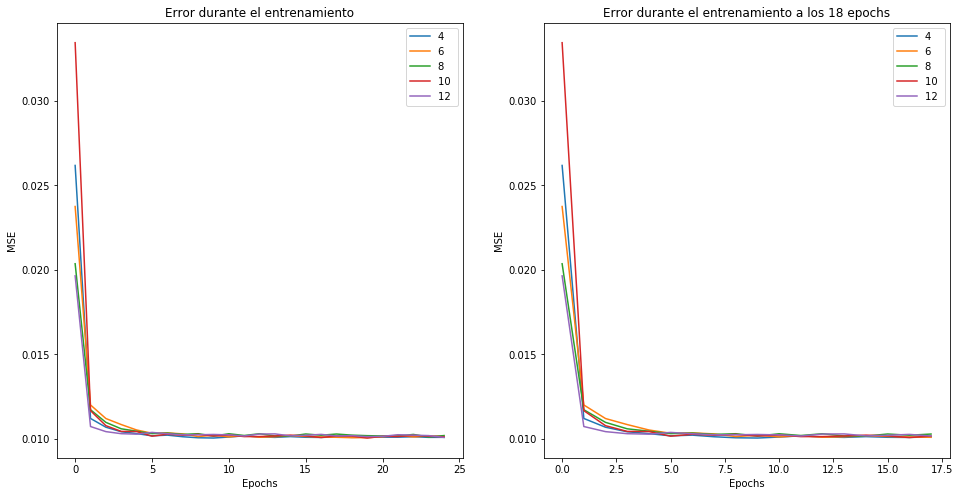

In [126]:
plot_multitrain(hist_val_bl, nb, epochs)

Mediante las gráficas anteriores no es posible clarificar de forma simple cual es la mejor elección del parámetro de clantidad de bloques. 

Analizando la función de pérdida (MSE) en el conjunto de entrenamiento es posible ver la clara tendencia de que para cual cantidad de bloques, el MSE decae hasta su punto estacionario antes de los 5 epochs. Es posible notar como el cambio de la cantidad de bloques implica cual es el mayor MSE logrado, así, con 10 bloques se parte con el mayor MSE de entrenamiento superior a $0.03$, y con 12 bloques se parte con el menor MSE de entrenamiento inferior a $0.02$. Luego, la red con 12 bloques es la que alcanza el valor estacionario $0.01$ de forma más rápida.

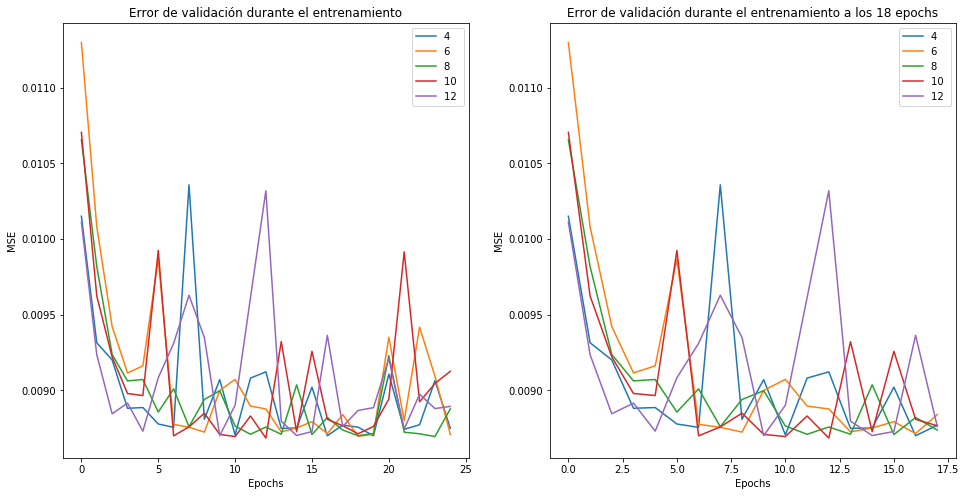

In [131]:
plot_multitrain_val(hist_val_bl, nb, epochs)

Analizando la función de pérdida (MSE) en el conjunto de validación es posible ver que no existe una clara tendencia de cuál red logra mejores resultados. Pero se puede ver como se mantiene que la red con 12 bloques marte con un menor valor, y alcanza su mínimo más rápido. Sin embargo, existe un elevado MSE en el epoch 12. 

Tomando todo el análisis anterior, se concluye que por poco que sea, la mejor opción para el párametro de cantidad de bloques es 12.

> k) Compare el desempeño de la red LSTM variando el lag de 1 a 4. Comente brevemente sobre qué resulta mejor, el tener mas información para predecir o si esto satura la predicción por el efecto del gradiente desvaneciente.

Ahora, en vez de modificar la cantidad de bloques se varía el *lag* con que se generan los inputs de las redes, por lo que será posible ver cuál es la mejor representación para la alimentar a la red. La variación del *lag* se produce entre 1 y 4. Para el análisis se estudia: tiempo de entrenamiento, RMSE de entrenamiento, MSE de entrenamiento y validación.

In [40]:
lags = range(1,5)
bloque = 12

hist_val_lag, data_val_lag = train_validation(bloque, lags, type_train='Lag')

Lag
1
2
3
4
╒═══════╤═════════╤══════════════╕
│   Lag │   Error │   Tiempo [s] │
╞═══════╪═════════╪══════════════╡
│     1 │ 2.7086  │      86.0068 │
├───────┼─────────┼──────────────┤
│     2 │ 2.70018 │      81.8991 │
├───────┼─────────┼──────────────┤
│     3 │ 2.67372 │      89.3143 │
├───────┼─────────┼──────────────┤
│     4 │ 2.57886 │      86.799  │
╘═══════╧═════════╧══════════════╛


Mediante la tabla anterior, se ve claramente la tendencia de que a mayor *lag* se produce un menor error RMSE, por lo que la red con *lag*=4 es la que mejor se comporta según esta métrica.

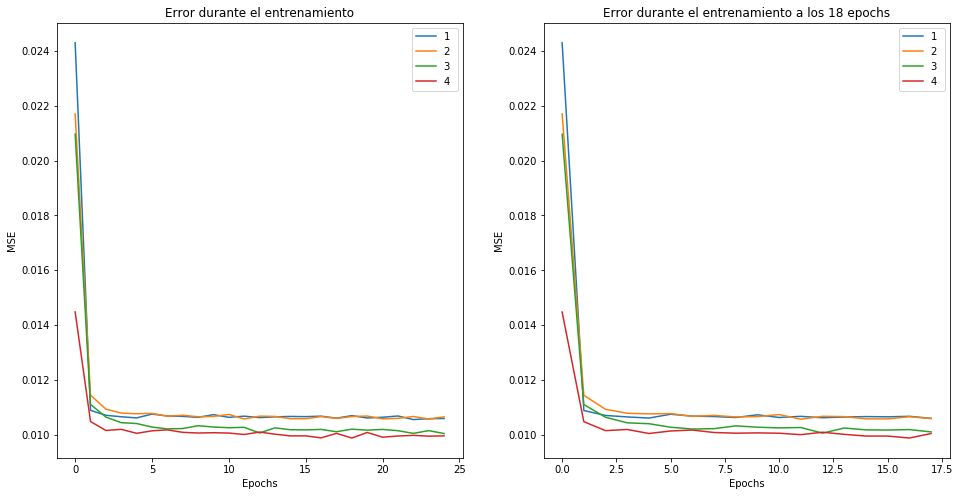

In [129]:
plot_multitrain(hist_val_lag, lags, epochs)

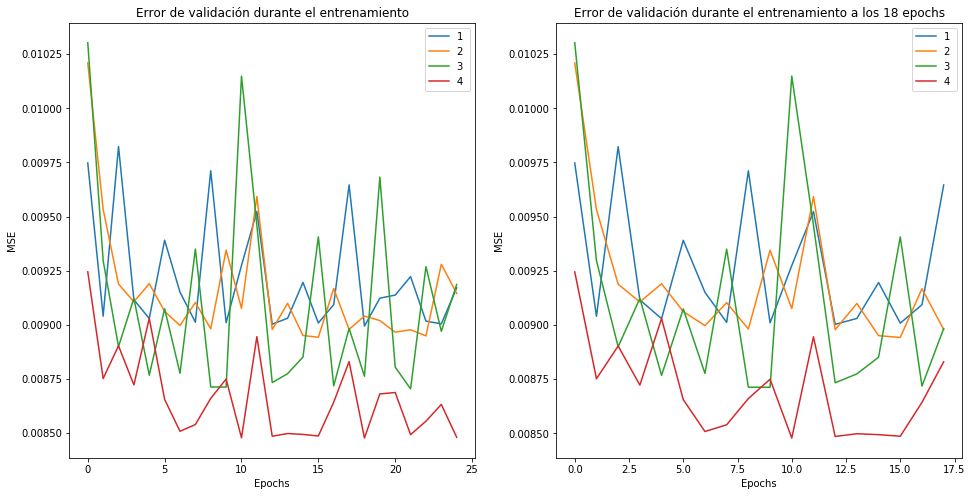

In [132]:
plot_multitrain_val(hist_val_lag, lags, epochs)

Mediante las gráficas anterior es posible ver como claramente el modelo con *lag*=4 es el que tiene un mejor rendimiento, alcanzando visiblemente el menor MSE tanto en el conjunto de entrenamiento como en el de validación. Con esto, es posible inferir que la red aprovecha de mejor forma la información entregada, pues a medida que aumenta la cantidad de caraterísticas entregadas para inferir un determinado target, la red puede comportarse de mejor forma. Lo anterior tiene mucho sentido, pues puede aprender más a medida que se le entregue más información, sin embargo, debe existir un punto en que tanta información ya no sea útil, produciendo overfitting o simplemente empeorando la capacidad de aprendizaje de la red y por ende las métricas analaizadas (RMSE, MSE y tiempo).

In [24]:
epochs = 25
batch_size=1

model_best = create_model(12, 4)  
train_x_best, train_y_best = create_dataset(stream_train_scaled, 4)
test_x_best, test_y_best = create_dataset(stream_test_scaled, 4)
val_x_best, val_y_best = create_dataset(stream_val_scaled, 4)
train_x_best = np.reshape(train_x_best, (train_x_best.shape[0], 1, train_x_best.shape[1]))
test_x_best = np.reshape(test_x_best, (test_x_best.shape[0], 1, test_x_best.shape[1]))
val_x_best = np.reshape(val_x_best, (val_x_best.shape[0], 1, val_x_best.shape[1]))
start_time = time.time()
hist_best = model_best.fit(train_x_best, train_y_best, epochs=epochs, batch_size=batch_size, 
                           validation_data=(val_x_best, val_y_best))
tiempo_best = time.time() - start_time 
score_train_best = compute_rmse(model_best, train_x_best, train_y_best, batch_size)
score_test_best = compute_rmse(model_best, test_x_best, test_y_best, batch_size)

print('Red Recurrente con bloque=12 y lag=4')
print('Tiempo de entrenamiento: ', tiempo_best, "[s]")
print('Train Score: ', score_train_best)
print('Test Score: ', score_test_best)


Train on 1496 samples, validate on 1646 samples
Epoch 1/25
1496/1496 [==============================] - 5s 3ms/step - loss: 0.0195 - val_loss: 0.0101
Epoch 2/25
1496/1496 [==============================] - 4s 3ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 3/25
1496/1496 [==============================] - 3s 2ms/step - loss: 0.0103 - val_loss: 0.0089
Epoch 4/25
1496/1496 [==============================] - 3s 2ms/step - loss: 0.0103 - val_loss: 0.0088
Epoch 5/25
1496/1496 [==============================] - 5s 3ms/step - loss: 0.0102 - val_loss: 0.0085
Epoch 6/25
1496/1496 [==============================] - 5s 3ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 7/25
1496/1496 [==============================] - 5s 3ms/step - loss: 0.0102 - val_loss: 0.0085
Epoch 8/25
1496/1496 [==============================] - 5s 3ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 9/25
1496/1496 [==============================] - 5s 3ms/step - loss: 0.0101 - val_loss: 0.0092
Epoch 10/25
1496/1496 [===========

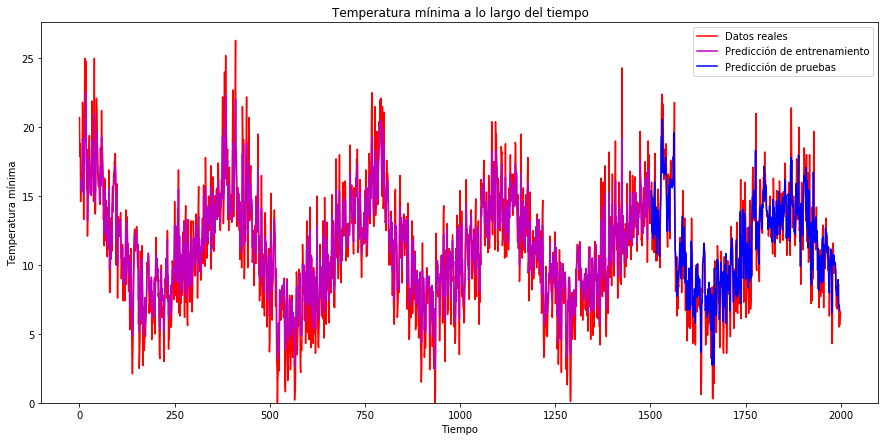

In [35]:
trainPredict_best = predict(model_best, train_x_best, batch_size)
testPredict_best  = predict(model_best, test_x_best,  batch_size) 

# shift train predictions for plotting
trainPredictPlot_best = np.empty_like(dataframe.values[:2000])
trainPredictPlot_best[:, :] = np.nan
trainPredictPlot_best[lag:len(trainPredict_best)+lag, :] = trainPredict_best

# shift test predictions for plotting
testPredictPlot_best = np.empty_like(dataframe.values[:2000])
testPredictPlot_best[:, :] = np.nan
testPredictPlot_best[(len(trainPredict_best)+2*lag):-2, :] = testPredict_best

plot_predict(dataframe, trainPredictPlot_best, testPredictPlot_best)

> l) Usando un lag de 3, compare el desempeño de la LSTM con una red recurrente simple y una GRU. Comente sobre la convergencia y el tiempo de ejecución.
```python
from keras.layers import GRU
from keras.layers import SimpleRNN
GRU(output_dim, inner_init='orthogonal', activation='tanh')
SimpleRNN(output_dim, inner_init='orthogonal',activation='tanh')
```

A continuación se entrenan dos redes recurrentes, primero una con modelo Gated Recurrent Unit (GRU) y luego una simple. Luego, estas dos redes son comparadas entre sí y con la red LSTM obtenida en el primer modelo LSTM (paso e).


In [52]:
lag = 3
batch_size=1
epochs = 25
time_compare = []
train_error = []
test_error = []

In [53]:
#use train_x_1, test_x_1 and val_x_1 they was create with this lag

#GRU model
model_gru= Sequential()
model_gru.add(GRU(units=4, input_shape=(None,train_x_1.shape[2]), recurrent_initializer='orthogonal', 
              activation='tanh'))
model_gru.add(Dense(1, activation = 'linear'))
start_time = time.time()
model_gru.compile(loss='mean_squared_error', optimizer='adam')
hist_gru = model_gru.fit(train_x_1, trainY, epochs=epochs, batch_size=batch_size, 
                         validation_data=(val_x_1, valY), verbose=0)
time_compare.append(time.time() - start_time)
train_error.append(compute_rmse(model_gru,train_x_1,trainY, batch_size))
test_error.append(compute_rmse(model_gru,test_x_1,testY, batch_size))


print('Red Recurrente GRU ')
print('Tiempo de entrenamiento: ', time_compare[-1], "[s]")
print('Train Score: ', train_error[-1])
print('Test Score: ', test_error[-1])

Red Recurrente GRU 
Tiempo de entrenamiento:  101.44335389137268 [s]
Train Score:  2.637780332570453
Test Score:  2.4337683562488373


In [54]:
model_simple = Sequential()
model_simple.add(SimpleRNN(units=4, input_shape=(None,train_x_1.shape[2]), recurrent_initializer='orthogonal',
                           activation='tanh'))
model_simple.add(Dense(1, activation = 'linear'))
start_time = time.time()
model_simple.compile(loss='mean_squared_error', optimizer='adam')
hist_simple = model_simple.fit(train_x_1, trainY, epochs=epochs, batch_size=batch_size, 
                         validation_data=(val_x_1, valY), verbose=0)
time_compare.append(time.time() - start_time)
train_error.append(compute_rmse(model_simple,train_x_1,trainY, batch_size))
test_error.append(compute_rmse(model_simple,test_x_1,testY,batch_size))

print('Red Recurrente Simple ')
print('Tiempo de entrenamiento: ', time_compare[-1], "[s]")
print('Train Score: ', train_error[-1])
print('Test Score: ', test_error[-1])

Red Recurrente Simple 
Tiempo de entrenamiento:  75.72284412384033 [s]
Train Score:  2.671347114766317
Test Score:  2.478329373827835


Se presenta una tabla y gráficos para poder realizar la comparación de los modelos de redes recurrentes.


╒═══════════════╤══════════════════════════╤═══════════════════╤══════════╕
│ Modelo        │   Error de entrenamiendo │   Error de prueba │   Tiempo │
╞═══════════════╪══════════════════════════╪═══════════════════╪══════════╡
│ Modelo GRU    │                  2.63778 │           2.43377 │ 101.443  │
├───────────────┼──────────────────────────┼───────────────────┼──────────┤
│ Modelo Simple │                  2.67135 │           2.47833 │  75.7228 │
├───────────────┼──────────────────────────┼───────────────────┼──────────┤
│ Modelo LSTM   │                  2.61859 │           2.41112 │ 100.907  │
╘═══════════════╧══════════════════════════╧═══════════════════╧══════════╛


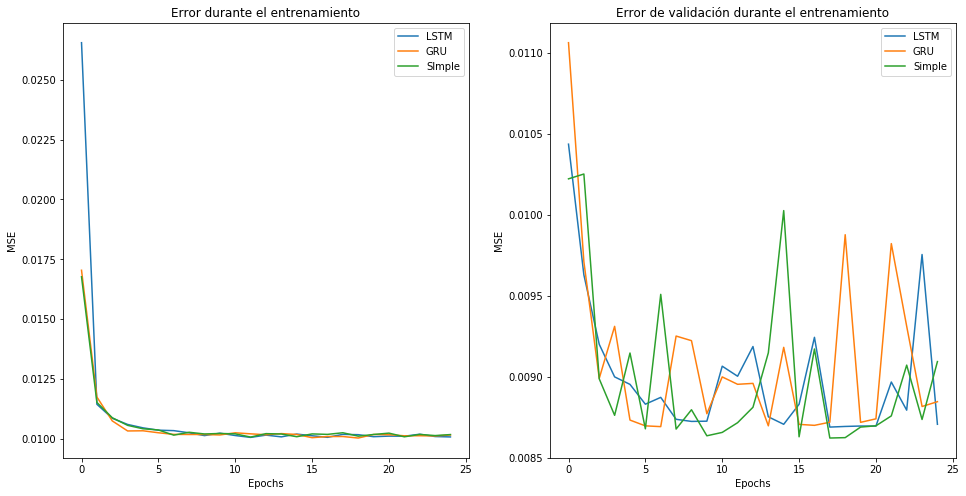

In [133]:
time_compare.append(time_model1) 
train_error.append(trainScore)
test_error.append(testScore)
header= ('Modelo', 'Error de entrenamiendo', 'Error de prueba', 'Tiempo')

data_compare = list(zip(['Modelo GRU','Modelo Simple', 'Modelo LSTM'],train_error, test_error, time_compare))
print(tabulate(data_compare, headers = header, tablefmt = "fancy_grid"))

plt.figure(1, figsize=(16,8))
plt.subplot(121)
plt.plot(range(epochs), hist_m1.history['loss'], label="LSTM")
plt.plot(range(epochs), hist_gru.history['loss'], label="GRU")
plt.plot(range(epochs), hist_simple.history['loss'], label="SImple")
plt.title("Error durante el entrenamiento")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(range(epochs), hist_m1.history['val_loss'], label="LSTM")
plt.plot(range(epochs), hist_gru.history['val_loss'], label="GRU")
plt.plot(range(epochs), hist_simple.history['val_loss'], label="Simple")
plt.title("Error de validación durante el entrenamiento")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

A través de la tabla se ve como el la red LSTM es la que tiene un mejor comportamiento de acuerdo al RMSE de entrenamiento y prueba. Aunque la diferencia con el siguiente modelo que mejor se comporta, GRU, es de tan solo 0.019211 en el error de entrenamiento y 0.02265 en el de prueba. Sin embargo, la red simple es la que se demora menos en entrenar y sus errores no son malos, al contrario son solo 0.05276 y 0.06721 diferentes con respecto a la red LSTM en error de entrenaiento y prueba, respectivamente.

Por otro lado, las gráficas de la función de pérdida a través de los epochs muestan que en el conjunto de entrenamiento la red LSTM es la que peor se comporta pues es la que parte desde un mayor valor en comparacion a  las otras dos redes, sin embargo, logra alcanzar el mismo valor $0.0100$ de MSE que la red simple y GRU en la misma cantidad de epochs aproximadamente. Ahora, en el conjunto de validación se puede ver como ninguna de las tres redes tiene una preponderacia sobre las otras, pero la que se podría llegar a decir uqe tiene un mejor comportamiento es la red simple al alcanzar por mayor cantidad de veces el menor valor, a pesar que en el epoch 14 tiene el MSE mas alto.

Así, para este caso de estudio las 3 redes estudiadas tienen un buen comportamiento, sin que alguna sobresalga claramente por tener un mejor rendimiento que las otras, pero si se tuviese que elegir una estaría entre la LSTM y la simple.

> m) Entrene la red LSTM con memoria entre batches. Grafique las predicción, comente si de esta forma mejora la predicción.
```python
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(25):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()
```

Se entrena una red LSTM con memoria entre batches, lo que implica activar el parámetro *stateful* y resetear los estados en cada fit. Esto último quiere decir que se guardan los pesos que tiene la red actualmente para el próximo elemento del batch, de esta forma se ayuda  cuando se utilizan *batch_size* igual a 1, ya que puede "recordar" el estado y no volver a calcular todo desde cero.

In [45]:
batch_size = 1
model3 = Sequential()
model3.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model3.add(Dense(1,activation='linear'))
model3.compile(loss='mean_squared_error', optimizer='adam')
hist_m3 = []
start_time = time.time()
for i in range(25):
    hist_m3.append(model3.fit(train_x_2, trainY, epochs=1, batch_size=batch_size, validation_data=(val_x_2, valY), verbose=1, shuffle=False))
    model3.reset_states()
time_m3 = time.time() - start_time
e_train_m3 = compute_rmse(model3,train_x_2,trainY,batch_size)
e_test_m3 = compute_rmse(model3,test_x_2,testY,batch_size)

print('LSTM con memoria entre batches')
print('Tiempo de entrenamiento: ', time_m3, "[s]")
print('Train Score: ', e_train_m3)
print('Test Score: ', e_test_m3)

Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 7s 4ms/step - loss: 0.0256 - val_loss: 0.0222
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 6s 4ms/step - loss: 0.0117 - val_loss: 0.0205
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 6s 4ms/step - loss: 0.0112 - val_loss: 0.0191
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 7s 4ms/step - loss: 0.0108 - val_loss: 0.0180
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 6s 4ms/step - loss: 0.0105 - val_loss: 0.0172
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 6s 4ms/step - loss: 0.0102 - val_loss: 0.0166
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 6s 

Revisando los errores RMSE de entrenamiento y prueba se puede ver que no son mejores que las redes anteriores, se hecho es la única red hasta el momento que obtiene un error de $3$ en ambos conjuntos de datos. Y también es de las que obtiene un mayor tiempo de entrenamiento, siendo superado únicamente por el modelo de la letra i.

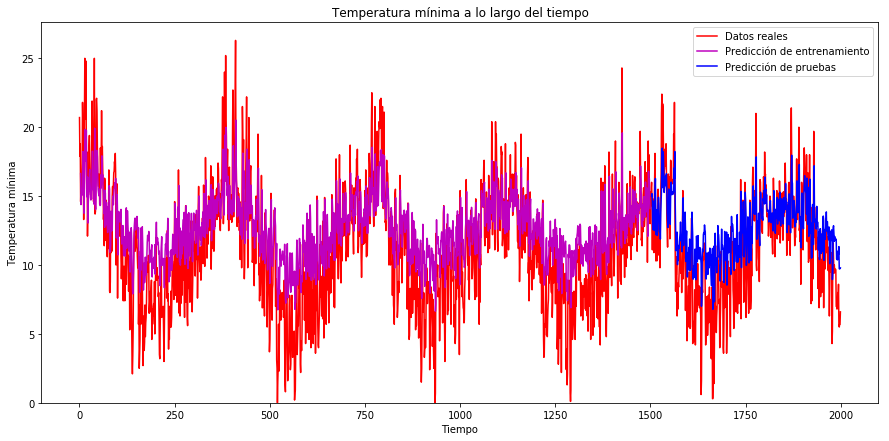

In [57]:
trainPredict_3 = predict(model3, train_x_2, batch_size)
testPredict_3  = predict(model3, test_x_2,  batch_size) 
trainPredictPlot_3, testPredictPlot_3 = shift_predict(dataframe, trainPredict_3, testPredict_3)
plot_predict(dataframe, trainPredictPlot_3, testPredictPlot_3)

Estudiando la gráfica de las predicciones realizadas por esta red comparándolas con las reales, se puede ver como esto corrobora el mayor error RMSE visto en la tabla. Es posible verificar que las predicciones realizadas son peores, pues se desplazan hacia arriba, obteniendo temperaturas mínimas más altas de las reales, y aún sigue sin poder alcanar a predecir temperaturas extremas.

Así, a diferencia de lo que se podría haber pensado a priori, las prediciones realizadas con esta red LSTM con memoria entre batches son peores.

> n) Compare el resultado anterior usando un tamaño de batch, decidido por usted, mayor o igual a 3.

Ahora se modifica el *bacth_size* a 3 y se compara con los resultados obtenidos anteriormente.

In [47]:
batch_size = 3
model4 = Sequential()
model4.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model4.add(Dense(1,activation='linear'))
model4.compile(loss='mean_squared_error', optimizer='adam')
hist_m4 = []
start_time = time.time()
for i in range(25):
    hist_m4.append(model4.fit(train_x_2, trainY, epochs=1, batch_size=batch_size, validation_data=(val_x_2, valY), verbose=1, shuffle=False))
    model4.reset_states()
time_m4 = time.time() - start_time

Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0583 - val_loss: 0.0186
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0212 - val_loss: 0.0149
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0162 - val_loss: 0.0129
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0141 - val_loss: 0.0120
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 2s 1ms/step - loss: 0.0131 - val_loss: 0.0114
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 3s 2ms/step - loss: 0.0125 - val_loss: 0.0110
Train on 1497 samples, validate on 1647 samples
Epoch 1/1
1497/1497 [==============================] - 2s 

In [59]:
e_train_m4 = compute_rmse(model4,train_x_2,trainY,batch_size)
e_test_m4 = compute_rmse(model4,test_x_2[:495],testY[:495],batch_size)

print('LSTM con memoria entre batches')
print('Tiempo de entrenamiento: ', time_m4, "[s]")
print('Train Score: ', e_train_m4)
print('Test Score: ', e_test_m4)

LSTM con memoria entre batches
Tiempo de entrenamiento:  43.610870361328125 [s]
Train Score:  2.7954998065230967
Test Score:  2.585473518570683


Con estos resultado se puede apreciar inmediatamente que esta red se comporta mejor que la anterior, pues tiene un mejor RMSE tanto en entrenamiento como en prueba, ambos menor a 3, y también se tiene un menor tiempo de entrenamiento.

De igual forma, a continuación se realiza una comparación más específica entre ambas redes.

In [60]:
data_compare_batches = [[1, e_train_m3, e_test_m3, time_m3], [3, e_train_m4, e_test_m4, time_m4]]
header = ['Bath size', 'RMSE de entrenamiento', 'RMSE de prueba', 'Tiempo']
print(tabulate(data_compare_batches, headers = header, tablefmt = "fancy_grid"))

╒═════════════╤═════════════════════════╤══════════════════╤══════════╕
│   Bath size │   RMSE de entrenamiento │   RMSE de prueba │   Tiempo │
╞═════════════╪═════════════════════════╪══════════════════╪══════════╡
│           1 │                 3.27085 │          3.0376  │ 122.526  │
├─────────────┼─────────────────────────┼──────────────────┼──────────┤
│           3 │                 2.7955  │          2.58547 │  43.6109 │
╘═════════════╧═════════════════════════╧══════════════════╧══════════╛


Con la tabla anterior podemos verificar que efectivamente la red con *batch_size* igual a 3 tiene un mejor rendimiento, teniendo una diferencia de 0.47535 y 0.45213 en el RMSE de entrenamiento y prueba, respectivamente, lo cual no es tan insignificante como en los casos anteriores, en donde la diferencia estaba en el orden del 0.02

In [61]:
plot_hist_m3 = []
plot_hist_m4 = []
aux_3_1 = []
aux_3_2 = []
aux_4_1 = []
aux_4_2 = []
for i in range(len(hist_m3)):
    aux_3_1.append(hist_m3[i].history['loss'])
    aux_3_2.append(hist_m3[i].history['val_loss'])
    
    aux_4_1.append(hist_m4[i].history['loss'])
    aux_4_2.append(hist_m4[i].history['val_loss'])    
    
plot_hist_m3.append(aux_3_1)
plot_hist_m3.append(aux_3_2)

plot_hist_m4.append(aux_4_1)
plot_hist_m4.append(aux_4_2)

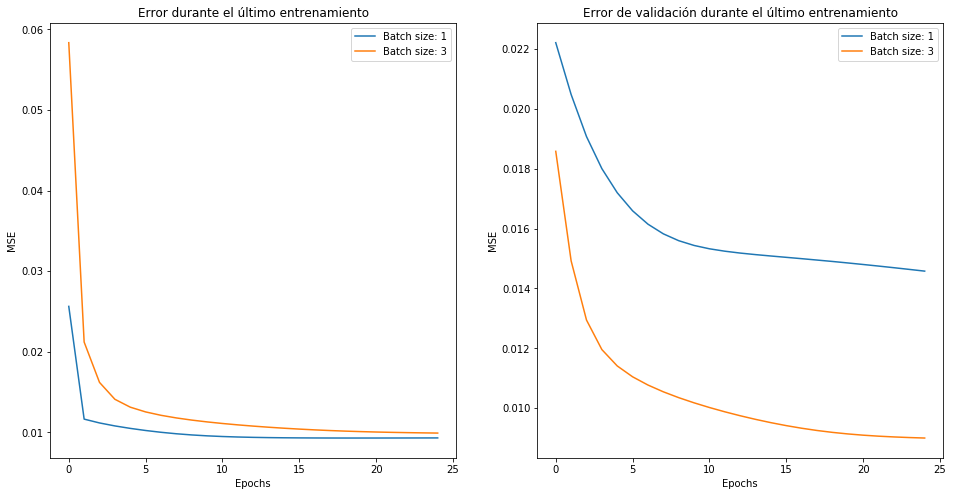

In [64]:
hists = list([hist_m3, hist_m4])
#plot_multitrain(hists, [1, 3], epochs)
epochs = 1
plt.figure(1, figsize=(16,8))
plt.subplot(121)
plt.plot(range(25), plot_hist_m3[0], label="Batch size: 1")
plt.plot(range(25), plot_hist_m4[0], label="Batch size: 3")
plt.title("Error durante el último entrenamiento")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(122)
plt.plot(range(25), plot_hist_m3[1], label="Batch size: 1")
plt.plot(range(25), plot_hist_m4[1], label="Batch size: 3")
plt.title("Error de validación durante el último entrenamiento")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Mediante el gráfico del MSE del conjunto de entrenamiento, se ve como la red de *batch_size*=1 tiene un menor error que la red de *batch_size*=3, aunque esta diferencia sea pequeña a medida que avanza los epochs. Sin embargo, al revisar el MSE del conjunto de validación, se ve como la red de *batch_size*=3 se comporta mucho, obteniendo valores más bajo en todo momento. Por lo tanto, se cree que es mejor la red con *batch_size*=3.

> o) Construya una LSTM apilada, y compárela con la obtenida en i). Comente brevemente lo sucedido.
```python
model.add(LSTM(4, input_dim=1, return_sequences=True))
model.add(LSTM(4))
```

Se entrena una nueva red LSTM, pero esta vez apilada, es decir, agregándole una capa oculta LSTM con memoria entre batches. Luego, esta será comparada con una red LSTM ocupada anteriormente en la  letra i.

In [65]:
batch_size = 1
epochs=25

model5 = Sequential()

model5.add(LSTM(4, input_shape=(lag,1), return_sequences=True))#, recurrent_activation='sigmoid'))
model5.add(LSTM(4))
model5.add(Dense(1, activation ='linear'))
model5.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
hist_m5 = model5.fit(train_x_2, trainY, epochs=epochs, batch_size=batch_size, validation_data=(val_x_2, valY), shuffle=False)
time_m5 = time.time() - start_time
e_train_m5 = compute_rmse(model5,train_x_2,trainY,batch_size)
e_test_m5 = compute_rmse(model5,test_x_2,testY,batch_size)    
  
    
print('Tiempo de entrenamiento: ', time_m5, "[s]")
print('Train Score: ', e_train_m5)
print('Test Score: ', e_test_m5)

Train on 1497 samples, validate on 1647 samples
Epoch 1/25
1497/1497 [==============================] - 14s 9ms/step - loss: 0.0312 - val_loss: 0.0263
Epoch 2/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0124 - val_loss: 0.0251
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0122 - val_loss: 0.0243
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0122 - val_loss: 0.0236
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0121 - val_loss: 0.0228
Epoch 6/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0120 - val_loss: 0.0220
Epoch 7/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0118 - val_loss: 0.0212
Epoch 8/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0117 - val_loss: 0.0203
Epoch 9/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0115 - val_loss: 0.0193
Epoch 10/25
1497/1497 [==

Nuevamente, se obtiene el caso en donde inmediatamente se da cuenta que el resultado obtenido con esta red LSTM apilada es peor, dado que tiene un error RMSE tanto de entrenamiento como de prueba mayor a 3.

Aún así, se realizará una comparación más detallada con la red LSTM del paso i.

In [66]:
data_compare_lstm = [["LSTM", e_train_m2, e_test_m2, time_m2], ["LSTM apilada", e_train_m5, e_test_m5, time_m5]]
header = ['Modelo', 'RMSE de entrenamiento', 'RMSE de prueba', 'Tiempo']
print(tabulate(data_compare_lstm, headers = header, tablefmt = "fancy_grid"))

╒══════════════╤═════════════════════════╤══════════════════╤══════════╕
│ Modelo       │   RMSE de entrenamiento │   RMSE de prueba │   Tiempo │
╞══════════════╪═════════════════════════╪══════════════════╪══════════╡
│ LSTM         │                 2.62029 │          2.41636 │  136.304 │
├──────────────┼─────────────────────────┼──────────────────┼──────────┤
│ LSTM apilada │                 3.3001  │          3.08091 │  286.115 │
╘══════════════╧═════════════════════════╧══════════════════╧══════════╛


La tabla demuestra lo indicado anteriormente, donde la diferencia es de 0.6798 y 0.6645 en el RMSE de entrenamiento y prueba, respectivamente.

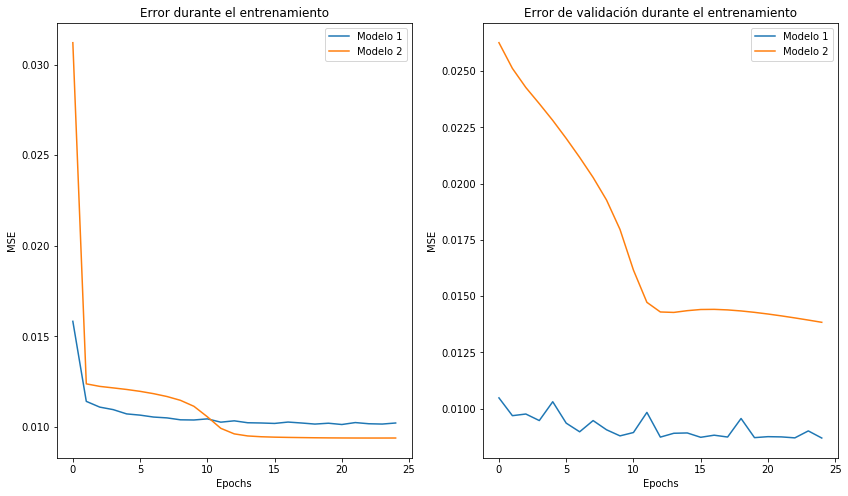

In [67]:
plot_compare_2(hist_m2, hist_m5, "Modelo 1", "Modelo 2", epochs)

Analizando la fundión de pérdida durante el entrenamiento se ve que el modelo 1, o sea la red LSTM sin apilar tiene un mejor comportamiento. A pesar de que la LSTM apilada obtiene un menor MSE en el conjunto de entrenamiento, ésta se demora más en llegar a ese estado, además que parte desde un valor muy elevado de MSE de entrenamiento y el MSE en el conjunto de validación no se condice con el menor valor obtenido en el entrenamiento, dado que deja mucho que desear, pues ni se acerca a la curva del modelo 1, LSTM sin apilar.


In [52]:
print(model2.summary())
print(model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 4)                 96        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 3, 4)              96        
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 144       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________

El pero rendimiento de la red LSTM apilada puede ser explicado por el hecho de que en una red profunda a cantidad de parámetros aumentan exponencialmente al agregar capas, como se ve en los resúmenes de los modelos estudiados. Por lo que sería necesario entregar más datos a la red para que logre un mejor performance.

> p) Sobre algunas de las redes definidas anteriormente deberá graficar el valor real vs la predicción del conjunto de pruebas tomando el primer dato (con sus $t$ timesteps) como inicio de la predicción y luego para predecir el siguiente valor se toman los $t-1$ timesteps mas el valor de predicción del primer dato, y así hasta cubrir todos los datos de pruebas. Dicho de otra forma, para los $N_t$ datos/mediciones del conjunto de pruebas, se requiere predecir los $N_t-t$ valores a partir de algun valor $p$, de la siguiente manera: $$
\hat{x}_{p} = f(x_{p-t},x_{p-t+1},\cdots,x_{p-1}) \\
\hat{x}_{p+1} = f(x_{p+1-t},x_{p+1-t+1},\cdots,x_{p-1},\hat{x}_{p}) \\
\hat{x}_{p+2} = f(x_{p+2-t},x_{p+2-t+1},\cdots,\hat{x}_{p},\hat{x}_{p+1}) \\
\cdots \\
\hat{x}_{N_t} = f(\hat{x}_{N_t-t},\hat{x}_{N_t-t+1},\cdots,\hat{x}_{N_t-2},\hat{x}_{N_t-1})
$$

Para realizar la predicción se toman las primeras 4 temperaturas. Luego, se comienza a realizar las predicciones, deslizando una ventana para obtener los datos de las predicciones realizadas.

Utilizando el primer modelo entrenado. 


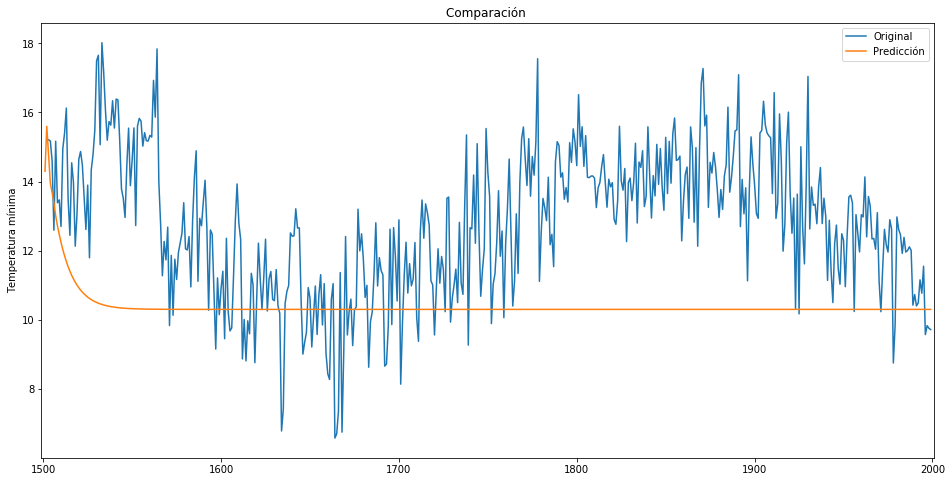

In [124]:
predict_test_5 = []
predict_test_5[:4] = test_x_1[0][0]
shape = np.empty(shape=(1,test_x_1[0].shape[0], test_x_1[0].shape[1]))

for i in range(len(test_x_2)):
    shape[0][0] = predict_test_5[i:i+lag]
    pred = model1.predict(shape, batch_size)
    predict_test_5.append(pred)

predictions_5 = scaler.inverse_transform([predict_test_5]).reshape(-1,1 ) 
predict = np.empty_like(dataframe.values[:2000])
predict[:, :] = np.nan
predict[1501:, :] = predictions_5[1:]

plt.figure(1, figsize=(16,8))
plt.plot(range(len(testPredictPlot_5)), testPredictPlot_5, label = "Original")
plt.plot(range(len(predict)), predict, label = "Predicción")
plt.title("Comparación ")
plt.legend()
plt.ylabel('Temperatura mínima')
plt.xlim([1499,2001])
plt.show()

Se puede ver un comportamient bastante extraño de primera impresión, pero analizando mejor como se realizó la predicción en este caso, se puede explicar que es lo que está sucediendo. En los primeros epochs de prediccion, los cuales a su vez corresponden los seteados desde el conjunto de pruebas, es donde se ve una variació en la predicción, de hecho se ve como está cerca del valor real. Pero luego, la predicción se aleja de los valores reales quedando estancada en una temperatura cercana a los 10°. Esto se da en el momento en que las predicciones comienzan a ser hechas en base a las predicciones anteriores. De esta forma es posible inferir que la red necesita de una inyección de valores externos para poder predecir bien.